In [1]:
from __future__ import print_function
from pathlib import Path
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize
import warnings

%matplotlib inline

In [2]:
cd ../libs

/Users/zilewang/Desktop/bda/music_emotion_recognition/libs


In [3]:
from rp_extract.rp_extract import rp_extract
from rp_extract.audiofile_read import *
from rp_extract.rp_plot import *

In [4]:
cd ../notebooks

/Users/zilewang/Desktop/bda/music_emotion_recognition/notebooks


In [5]:
audio_path = Path.cwd().parent / '1000songs' / 'clips_45seconds'
print(str(audio_path))

/Users/zilewang/Desktop/bda/music_emotion_recognition/1000songs/clips_45seconds


## Part I: Feature Extraction

### href = https://ccrma.stanford.edu/workshops/mir2010/SpeakerRecognition.pdf

In [6]:
from scipy import stats

def get_sfm(x):
    return scipy.stats.mstats.gmean(x) / np.mean(x)

def get_scf(x):
    return np.max(x) / np.mean(x) 

In [48]:
def append_val(d, k, v):
    if k not in d:
        d[k] = [v]
    else:
        d[k].append(v)
    return d

# The Melody&Harmonic Feature
def salient_pitch(y, sr):
    salient_pitch_index = [i+1 for i in range(1000)]
    salient_pitch_columns = ['salient_pitch_mean', 'salient_pitch_variance']
    salient_pitch_1000_songs = np.zeros(shape = (1000,2))
    
    per_sample_t = 1.0 / sr
    pitch_frame_length, pitch_hop_length = int(50 / 1000 / per_sample_t), int(25 / 1000 / per_sample_t)
    # we hope to introduce an acf - filtered salient pitch
    salient_pitch = []
    num_total_frames = (len(y) - pitch_frame_length) // pitch_hop_length + 1
    for i in range(num_total_frames):
        acf = librosa.core.autocorrelate(y[i*pitch_hop_length : (i*pitch_hop_length+pitch_frame_length)])
        # introduce a filtered acf method
        for j in range(1, len(acf) - 1):
            if acf[j] > acf[j-1] and acf[j] > acf[j+1]:
                if j >= 20 and acf[j] == np.max(acf[j-20:j+20]): # reducing the adjacent HF fluctuation
                    salient_pitch.append(sr / j)
                    break
    return np.array(salient_pitch, dtype = float)

def chroma_centroid(y, sr):
    per_sample_t = 1.0 / sr
    chromagram_frame_length, chromagram_hop_length = int(100 / 1000 / per_sample_t), int(12.5 / 1000 / per_sample_t)
    chromagram_center = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=chromagram_frame_length, \
                                                      hop_length=chromagram_hop_length)[0]
    
    return chromagram_center[1:]

def key_clarity_mode(y, sr): # key clarity -> max intensity mean , mode : max major - max minor
    major_index, minor_index = np.array([0,2,4,5,7,9,11], dtype = int), np.array([1,3,6,8,10], dtype = int)
    major_minor_key_clarity = np.zeros(shape = 2, dtype = int) 
    
    per_sample_t = 1.0 / sr
    chromagram_frame_length, chromagram_hop_length = int(100 / 1000 / per_sample_t), int(12.5 / 1000 / per_sample_t)
    chromagram = librosa.feature.chroma_stft(y, sr=sr, n_fft= chromagram_frame_length, \
                                             hop_length = chromagram_hop_length, \
                                             win_length = chromagram_frame_length, window = 'hamming', \
                                             n_chroma = 12)
    mode = []
    # zero-column delete
    k, ln_chro = 0, chromagram.shape[1]
    while k < ln_chro:
        if k >= chromagram.shape[1]:
            break
        if np.sum(chromagram[:,k]) == 0:
            chromagram = np.delete(chromagram, k, 1)
            k -= 1
        k += 1   
    major_chro = np.array([chromagram[0,:], chromagram[2,:], chromagram[4,:], chromagram[5,:], chromagram[7,:], \
                 chromagram[9,:], chromagram[11,:]], dtype = float)
    minor_chro = np.array([chromagram[1,:], chromagram[3,:], chromagram[6,:], chromagram[8,:], chromagram[10,:]],\
                          dtype = float)
    key_clarity = []
    
    key_index = np.argmax([np.mean(chromagram[k,:]) for k in range(12)])
    key_clarity.append(np.mean(chromagram[key_index, :]))
    key_clarity.append(np.std(chromagram[key_index, :]))
    
    major_minor_key_clarity[0] = major_index[np.argmax([np.sum(major_chro[k,:]) for k in range(7)])]
    major_minor_key_clarity[1] = minor_index[np.argmax([np.sum(minor_chro[k,:]) for k in range(5)])]
    dif_sum = []
    for j in range(chromagram.shape[1]):
        dif_sum.append(chromagram[major_minor_key_clarity[0], j] - \
                       chromagram[major_minor_key_clarity[1], j])
    mode.append(np.mean(dif_sum))
    mode.append(np.var(dif_sum))
    
    return np.array([key_clarity[0], key_clarity[1], mode[0], mode[1]], dtype = float)

def harmonic_change(y,sr):
    phi = np.array([[np.sin(i * 7 * np.pi / 6) for i in range(12)],\
                [np.cos(i * 7 * np.pi / 6) for i in range(12)],\
                [np.sin(i * 3 * np.pi / 2) for i in range(12)],\
                [np.cos(i * 3 * np.pi / 2) for i in range(12)],\
                [0.5*np.sin(i * 2 * np.pi / 3) for i in range(12)],\
                [0.5*np.cos(i * 2 * np.pi / 3) for i in range(12)]])
    phi = np.matrix(phi, dtype=float)
    
    per_sample_t = 1.0 / sr
    chromagram_frame_length, chromagram_hop_length = int(100 / 1000 / per_sample_t), int(12.5 / 1000 / per_sample_t)
    chromagram = librosa.feature.chroma_stft(y, sr=sr, n_fft= chromagram_frame_length, \
                                             hop_length = chromagram_hop_length, \
                                             win_length = chromagram_frame_length, window = 'hamming', \
                                             n_chroma = 12)
    # zero-column delete
    k, ln_chro = 0, chromagram.shape[1]
    while k < ln_chro:
        if k >= chromagram.shape[1]:
            break
        if np.sum(chromagram[:,k]) == 0:
            chromagram = np.delete(chromagram, k, 1)
            k -= 1
        k += 1
    zeta = np.zeros(shape = (6, chromagram.shape[1]))
    for j in range(chromagram.shape[1]):
        zeta[:,j] = np.dot(phi, chromagram[:,j]) / np.abs(np.sum(chromagram[:,j]))
    delta = []
    for j in range(1, chromagram.shape[1] - 1):
        delta.append(np.sum((zeta[:,j-1] - zeta[:,j+1]) ** 2))
    
    return np.array([np.mean(delta), np.std(delta)], dtype = float)

# The Spectral Feature
def sfm_scf_mfcc(y, sr):
    per_sample_t = 1.0 / sr
    
    pitch_frame_length, pitch_hop_length = int(50 / 1000 / per_sample_t), int(25 / 1000 / per_sample_t)    
    all_frame_fft = librosa.core.stft(y, n_fft = pitch_frame_length, hop_length=pitch_hop_length, \
                                     window = 'rect')
    all_frame_fft_energy = np.absolute(all_frame_fft) ** 2
   
    n_fft, num_frame = all_frame_fft_energy.shape[0], all_frame_fft_energy.shape[1]
    
    # zero-column delete
    k = 0
    while k < num_frame:
        if k >= all_frame_fft_energy.shape[1]:
            break
        if np.sum(all_frame_fft_energy[:,k]) == 0:
            all_frame_fft_energy = np.delete(all_frame_fft_energy, k, 1)
            k -= 1
        k += 1
    num_frame = all_frame_fft_energy.shape[1]
    
    all_frame_fft_sfm = np.array([[get_sfm(all_frame_fft_energy[n_fft // 17 * i:n_fft // 17 *(i+1), j]) \
                                   for j in range(num_frame)] for i in range(8)], dtype = float)
    
    all_frame_fft_scf = np.array([[get_scf(all_frame_fft_energy[n_fft // 17 * i:n_fft // 17 *(i+1), j]) \
                                   for j in range(num_frame)] for i in range(8)], dtype = float)
    
    song_sfm_mean = np.mean(all_frame_fft_sfm, axis = 1) # by row
    song_sfm_std = np.std(all_frame_fft_sfm, axis = 1) # by row
    
    song_scf_mean = np.mean(all_frame_fft_sfm, axis = 1) # by row
    song_scf_std = np.std(all_frame_fft_sfm, axis = 1) # by row
    
    mfcc = librosa.feature.mfcc(y, sr)
    song_mfcc = mfcc[:13, :]
    song_mfcc_mean = np.mean(song_mfcc, axis = 1)
    song_mfcc_std = np.std(song_mfcc, axis = 1)
    
    song_spectral_length = ( len(song_mfcc_mean) + len(song_scf_mean) * 2 ) * 2
    
    return np.reshape(np.concatenate([song_sfm_mean, song_sfm_std, song_scf_mean, \
                           song_scf_std, song_mfcc_mean, song_mfcc_std]), newshape=song_spectral_length)

# The Temporal&Rhythmic Feature
def temporal_centroid(envelope):
    """computes the temporal centroid of an onset envelope"""
    D = np.abs(librosa.stft(envelope))
    times = librosa.times_like(D)

    onset_strength = librosa.onset.onset_strength(y=envelope, sr=sr)
    
    try:
        temporal_centroid = sum(onset_strength * times) / sum(onset_strength)
    except RuntimeWarning:
        temporal_centroid = np.nan
    
    return temporal_centroid

def log_attack_time(envelope, sr, thresh_percent):
    D = np.abs(librosa.stft(envelope))
    times = librosa.times_like(D)
    onset_strength = librosa.onset.onset_strength(y=envelope, sr=sr)
    
    stop_attack_index = np.argmax(onset_strength)
    stop_attack_value = envelope[stop_attack_index]
    thresh = stop_attack_value * thresh_percent / 100
    
    try:
        start_attack_index = [x > thresh for x in onset_strength].index(True)
    except ValueError:
        return np.nan
    
    if start_attack_index == stop_attack_index:
        start_attack_index -= 1

    log_attack_time =  np.log10(times[stop_attack_index] - times[start_attack_index])
    
    return log_attack_time

# Combining for output 
def extract_features(signal, sr):
    """Given and a signal and its sampling rate, compute all the features"""
    
    # Harmonic Features 
    # FIXME
    salient_pitches = salient_pitch(signal, sr)
    salient_features = np.array([np.mean(salient_pitches), np.std(salient_pitches)])
    
    chroma_centroids = chroma_centroid(signal, sr)
    chroma_features = np.array([np.mean(chroma_centroids), np.std(chroma_centroids)])
    
    key_clarity_mode_features = key_clarity_mode(signal, sr)
    
    harmonic_change_features = harmonic_change(signal, sr)
    
    sfm_scf_mfcc_features = sfm_scf_mfcc(signal, sr) 
    
    # Temporal Features
    onset_samples = np.unique(librosa.onset.onset_detect(signal, sr=sr, backtrack=True, units='samples'))
    all_envelopes = np.split(signal, onset_samples)
    
    zero_crossings = np.array([sum(librosa.zero_crossings(x, pad=False)) for x in all_envelopes])
    zero_features = np.array([np.mean(zero_crossings), np.std(zero_crossings)])
    
    temporal_centroids = np.array([temporal_centroid(x) for x in all_envelopes])
    temporal_centroids = temporal_centroids[~np.isnan(temporal_centroids)]
    temporal_cen_features = np.array([np.mean(temporal_centroids), np.std(temporal_centroids)])
    
    log_attacks = np.array([log_attack_time(x, sr, 50) for x in all_envelopes])
    log_attacks = log_attacks[~np.isnan(log_attacks)]
    log_attack_features = np.array([np.mean(log_attacks), np.std(log_attacks)])
    
    # Rhythmic Feautres (without dimension reduction for now)
    rhythm = rp_extract(signal, sr, extract_rh=True, transform_db=True, transform_phon=True, transform_sone=True,          
        fluctuation_strength_weighting=True, 
        skip_leadin_fadeout=1,             
        step_width=1)
    rhythm_hist = rhythm['rh']
    rhythm_mean = np.array([np.mean(rhythm_hist)])
    
    # FIXME
    all_features = np.concatenate([salient_features, chroma_features, key_clarity_mode_features, \
                                   harmonic_change_features, sfm_scf_mfcc_features,  \
                                   zero_features, temporal_cen_features, \
                                   log_attack_features, rhythm_hist, rhythm_mean])
    
    return all_features

### [Important]: Filter out songs that are not in KDE annotations

In [49]:
# I cannot here apply pd.read_csv('../time_average.csv', header = 0)
kernel_density = pd.read_csv(r'Time_Average_Gamma03.csv', header=0)
song_id_in_kde = kernel_density.song_id.unique() # use song_id instead of dataframe.index

In [50]:
import glob
warnings.filterwarnings('ignore')
#all_mp3_paths = list(glob.glob(str(audio_path) + '/***.mp3'))
all_mp3_paths = list(audio_path.glob('**/*.mp3'))
song_ids = []
audio_train = [] 
## FIXME 
for path in tqdm(all_mp3_paths):
    song_id = int((str(path).split('/')[-1].split('.')[0]))
    if song_id not in song_id_in_kde:
        continue
    else: #we'll start off with only 100 training pieces to save time
        signal, sr = librosa.load(str(path))
        try:
            song_features = extract_features(signal, sr)
            audio_train.append(song_features)
            song_ids.append(song_id)

        except ValueError as e:
            print(path)
            continue

audio_train = np.array(audio_train, dtype = float)

100%|██████████| 1000/1000 [1:11:32<00:00,  4.29s/it]


In [51]:
audio_train.shape

(744, 135)

In [52]:
song_ids = np.reshape(song_ids , (len(song_ids)))

### Try to construct the ordered all-features of 744 songs (those who are not in kde will not be considered as available for MER)

In [53]:
all_music_all_features = pd.DataFrame(index = song_ids, data=audio_train)
all_music_all_features = all_music_all_features.sort_index()
def turn_into_name(i):
    return str(i) + '.mp3'

all_music_all_features_new = all_music_all_features.reset_index()
all_music_all_features_new['index']
all_music_all_features_new['song_id'] = all_music_all_features_new['index'].apply(lambda i: turn_into_name(i))
all_music_all_features_new.drop(['index'], axis=1, inplace=True)

In [55]:
all_music_all_features_new.to_csv('all_songs_all_features.csv')

In [9]:
select = np.setdiff1d(song_id_in_kde, song_ids)
select

array([   2,    3,    4,    5,    7,    8,   10,   12,   13,   17, ...,  989,  990,  991,  993,  994,  995,  996,  997,  999, 1000])

In [10]:
# we need a test song
test_song = '60.mp3'
if int(test_song.split('.')[0]) in song_ids:
    print('Change a new song!')
else:
    signal, sr = librosa.load(str(audio_path / test_song))
    audio_test = extract_features(signal, sr)
    print('good')

good


## Part II: Kernel Density Estimation

In [11]:
kernel_density = pd.read_csv('Time_Average_Gamma1.csv', header=0)
kernel_density.head()

,song_id,"[0,0]","[0,1]","[0,2]","[0,3]","[0,4]","[0,5]","[0,6]","[0,7]","[0,8]",...,"[15,6]","[15,7]","[15,8]","[15,9]","[15,10]","[15,11]","[15,12]","[15,13]","[15,14]","[15,15]"
0,2,0.002567,0.003009,0.003422,0.003773,0.004035,0.004185,0.004210,0.004107,0.003886,...,0.002011,0.001972,0.001875,0.001730,0.001547,0.001342,0.001129,0.000922,0.000730,0.000560
1,3,0.002718,0.003161,0.003565,0.003896,0.004128,0.004239,0.004221,0.004073,0.003810,...,0.002044,0.001975,0.001850,0.001680,0.001478,0.001261,0.001043,0.000836,0.000650,0.000490
2,4,0.000559,0.000721,0.000902,0.001094,0.001287,0.001467,0.001621,0.001736,0.001802,...,0.004001,0.004293,0.004466,0.004504,0.004402,0.004171,0.003831,0.003411,0.002944,0.002463
3,5,0.001392,0.001793,0.002240,0.002711,0.003182,0.003618,0.003989,0.004262,0.004414,...,0.001644,0.001757,0.001819,0.001826,0.001777,0.001675,0.001531,0.001356,0.001165,0.000969
4,7,0.000285,0.000385,0.000505,0.000641,0.000789,0.000941,0.001088,0.001220,0.001325,...,0.004413,0.004947,0.005375,0.005661,0.005779,0.005717,0.005483,0.005096,0.004591,0.004008


## Part III: Mapping Factor Learning

In [12]:
lamda = 0.01

def RSS_L1(beta, X, y, lamda):
    y_hat = np.dot(X, beta)
    return np.sqrt(np.sum((y - y_hat)**2)) + lamda*np.sum(np.abs(beta))


beta0 = np.random.normal(0, 1, audio_train.shape[1])
bnds = []
for i in range(audio_train.shape[1]):
    bnds.append((0, None))
bnds = tuple(bnds)    

res = minimize(fun=RSS_L1, x0=beta0, args=(audio_train, audio_test, lamda), bounds=bnds)

#if normalization(force to 0,1) needed please add: constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
beta_hat = res.x
mapping_factors = beta_hat
print('The estimated β vector is: \n')
print(mapping_factors)

The estimated β vector is: 

[0.5135708  0.12192391 0.37151166 0.         0.         0.         0.         0.         0.         0.        ]


In [13]:
len(mapping_factors)

10

### Part IV: Emotion Space Mapping

In [14]:
pred_emotion = np.zeros(16 * 16)
for i, s_id in enumerate(song_ids):
    if (kernel_density.loc[kernel_density['song_id'] == s_id, ].shape[0] == 0):
        emotion_val = np.zeros(16 * 16)
    else: 
        emotion_val = kernel_density.loc[kernel_density['song_id'] == s_id, ]. \
                        drop(['song_id'], axis=1).values[0]
    pred_emotion += mapping_factors[i] * emotion_val
pred_emotion

array([0.00146109, 0.00178804, 0.00212318, 0.00244648, 0.0027358 , 0.00296929, 0.00312815, 0.00319914, 0.00317641, 0.00306225, ..., 0.00278855, 0.00299291, 0.00312275, 0.00316717, 0.00312216,
       0.00299117, 0.00278469, 0.00251889, 0.0022135 , 0.00188944])

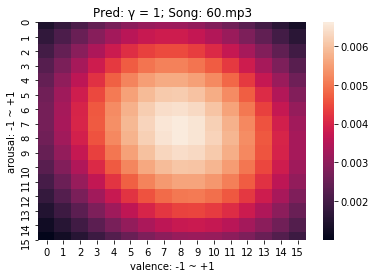

In [15]:
# Our prediction & actual
import seaborn as sns
pred_emotion_reshape = np.reshape(pred_emotion, (16, 16))
sns.heatmap(pred_emotion_reshape)
plt.xlabel('valence: -1 ~ +1')
plt.ylabel('arousal: -1 ~ +1')
plt.title('Pred: γ = 1; Song: 60.mp3')
plt.show()

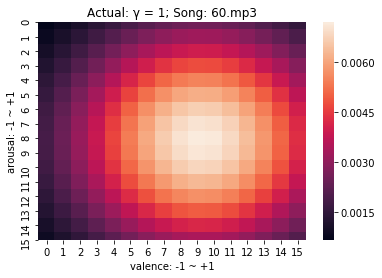

In [16]:
# Actual 
actual_emotion = kernel_density.loc[kernel_density['song_id'] == int(test_song.split('.')[0]), ]. \
                    drop(['song_id'], axis=1).values[0]
actual_emotion_reshape = np.reshape(actual_emotion, (16, 16))
sns.heatmap(actual_emotion_reshape)
plt.xlabel('valence: -1 ~ +1')
plt.ylabel('arousal: -1 ~ +1')
plt.title('Actual: γ = 1; Song: 60.mp3')
plt.show()

### scattering plot of actual & pred annotation of VA space

In [17]:
cd ../libs

/Users/zilewang/Desktop/bda/music_emotion_recognition/libs


In [18]:
cd ../notebooks

/Users/zilewang/Desktop/bda/music_emotion_recognition/notebooks


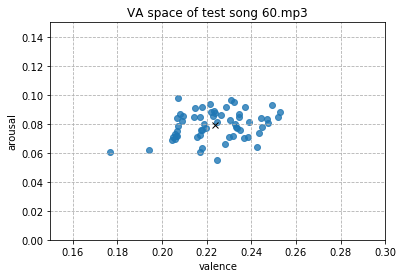

In [40]:
def scatter_plot_test_song_valence_arousal(test_song):
    #调用我们的valence 和 arousal 的 annotation
    arousal_path = Path.cwd().parent / '1000songs' / 'annotations'
    arousal = pd.read_csv(str(arousal_path) + '/arousal_cont_average.csv')
    valence = pd.read_csv(str(arousal_path) + '/valence_cont_average.csv')
    test_song_id = int(test_song.split('.')[0])

    #用第一列的song_id换成索引index
    temp_arousal = arousal.set_index('song_id')
    temp_valence = valence.set_index('song_id')

    #画图
    test_song_arousal = temp_arousal.loc[test_song_id]
    test_song_valence = temp_valence.loc[test_song_id]
    mean_arousal = np.mean(test_song_arousal)
    mean_valence = np.mean(test_song_valence)
    plt.scatter(test_song_valence, test_song_arousal, alpha=0.8)
    plt.plot(mean_valence, mean_arousal, 'x' ,c = 'black')
    plt.xlim(0.15,0.3)
    plt.ylim(0,0.15)
    plt.xlabel('valence')
    plt.ylabel('arousal')
    plt.title('VA space of test song %d.mp3' % test_song_id)
    plt.grid(ls = '--')
    plt.show()
    return 

scatter_plot_test_song_valence_arousal(test_song)

In [39]:
temp_arousal

,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,sample_19500ms,...,sample_40500ms,sample_41000ms,sample_41500ms,sample_42000ms,sample_42500ms,sample_43000ms,sample_43500ms,sample_44000ms,sample_44500ms,sample_45000ms
song_id,,,,,,,,,,,,,,,,,,,,,
2,-0.109388,-0.114943,-0.116414,-0.118614,-0.126458,-0.133200,-0.136857,-0.144714,-0.138987,-0.137604,...,-0.259550,-0.262237,-0.261481,-0.264916,-0.265397,-0.265162,-0.264470,-0.265842,-0.267091,-0.266345
3,-0.110847,-0.123974,-0.131104,-0.135957,-0.140777,-0.144664,-0.163118,-0.165218,-0.158859,-0.156783,...,-0.265929,-0.263960,-0.263571,-0.262956,-0.260337,-0.248710,-0.245516,-0.251299,-0.254619,-0.259586
4,0.222328,0.179448,0.178389,0.184057,0.176043,0.178720,0.176345,0.175793,0.176155,0.176605,...,0.298644,0.294144,0.302703,0.297487,0.303424,0.298097,0.304340,0.304115,0.305079,0.290705
5,-0.255613,-0.251578,-0.251957,-0.251123,-0.250762,-0.251957,-0.251957,-0.251957,-0.251957,-0.251957,...,-0.225898,-0.228913,-0.228913,-0.228913,-0.228913,-0.227561,-0.227609,-0.229996,-0.243920,-0.246009
7,0.464233,0.460788,0.460990,0.461046,0.457239,0.465701,0.471808,0.469918,0.473376,0.470050,...,0.333163,0.331243,0.333927,0.333740,0.340782,0.339002,0.339271,0.340961,0.342020,0.335976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.083658,-0.079965,-0.080614,-0.077533,-0.081066,-0.082564,-0.075276,-0.071917,-0.072352,-0.073255,...,-0.046469,-0.044649,-0.041990,-0.035563,-0.037822,-0.040367,-0.043850,-0.049861,-0.046132,-0.051784
996,0.340385,0.339627,0.340270,0.335955,0.338222,0.335331,0.340030,0.343517,0.347987,0.352064,...,0.364017,0.366737,0.366231,0.366730,0.365032,0.366610,0.367975,0.370551,0.369909,0.368717
997,0.367088,0.368839,0.352861,0.311679,0.278800,0.253148,0.249393,0.243813,0.238716,0.240276,...,0.257732,0.293368,0.312197,0.327872,0.337830,0.332809,0.332175,0.337198,0.353745,0.353280
